In [37]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing, ETSModel, seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# Custom modules
# from scripts.plotting import *
# from scripts.utils import *
# Plot defaults
px.defaults.height = 400; px.defaults.width = 620
plt.style.use(plt.style.available[4]); plt.rcParams.update({"font.size": 16, "figure.figsize": (20,5), "lines.linewidth": 2})

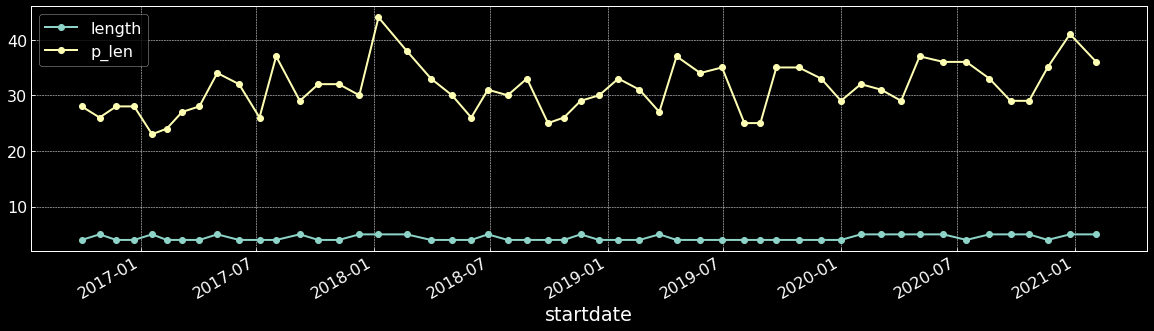

In [53]:
df = pd.read_csv('data/sis.csv', index_col=0, parse_dates=True)
df.plot.line(marker='o')
plt.show()

In [59]:
df.head()

,length,p_len
startdate,,
2016-10-01,4,28
2016-10-29,5,26
2016-11-24,4,28
2016-12-22,4,28
2017-01-19,5,23


In [65]:
df1 = df.resample("1M").mean()
df1 = df1.interpolate(method="linear")
df1;

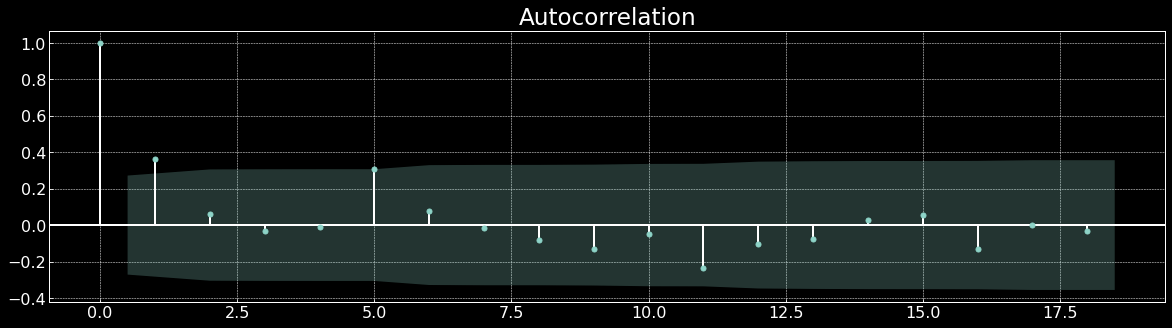

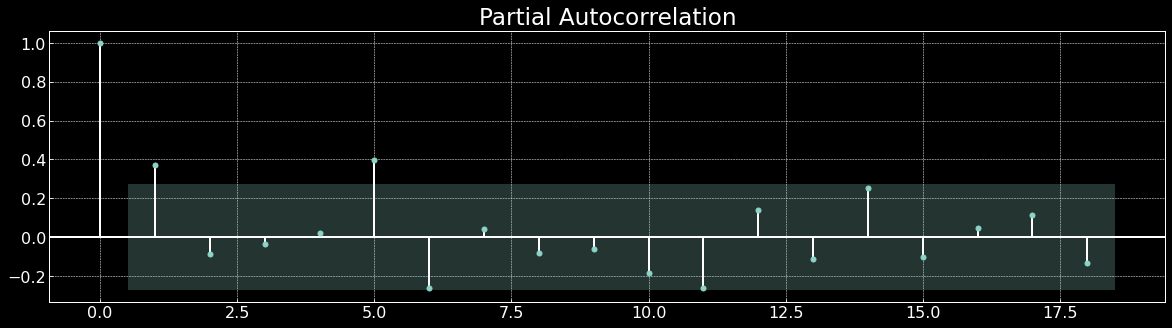

In [62]:
plot_acf(df.p_len), plot_pacf(df.p_len);

<AxesSubplot:xlabel='startdate'>

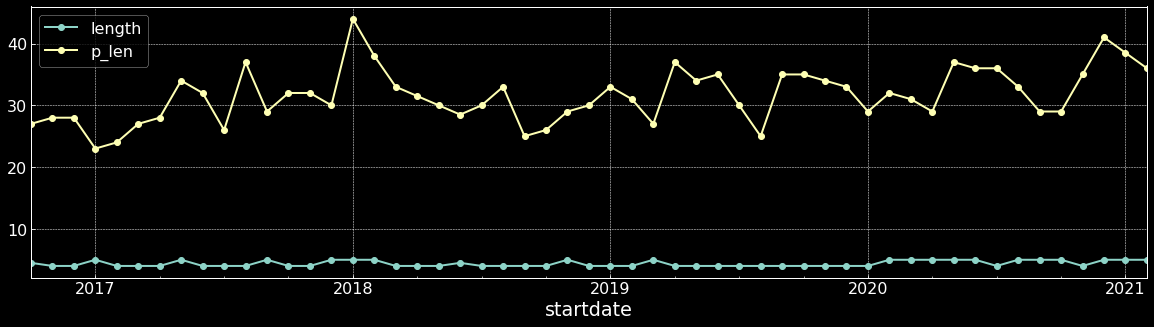

In [66]:
df1.plot.line(marker='o')

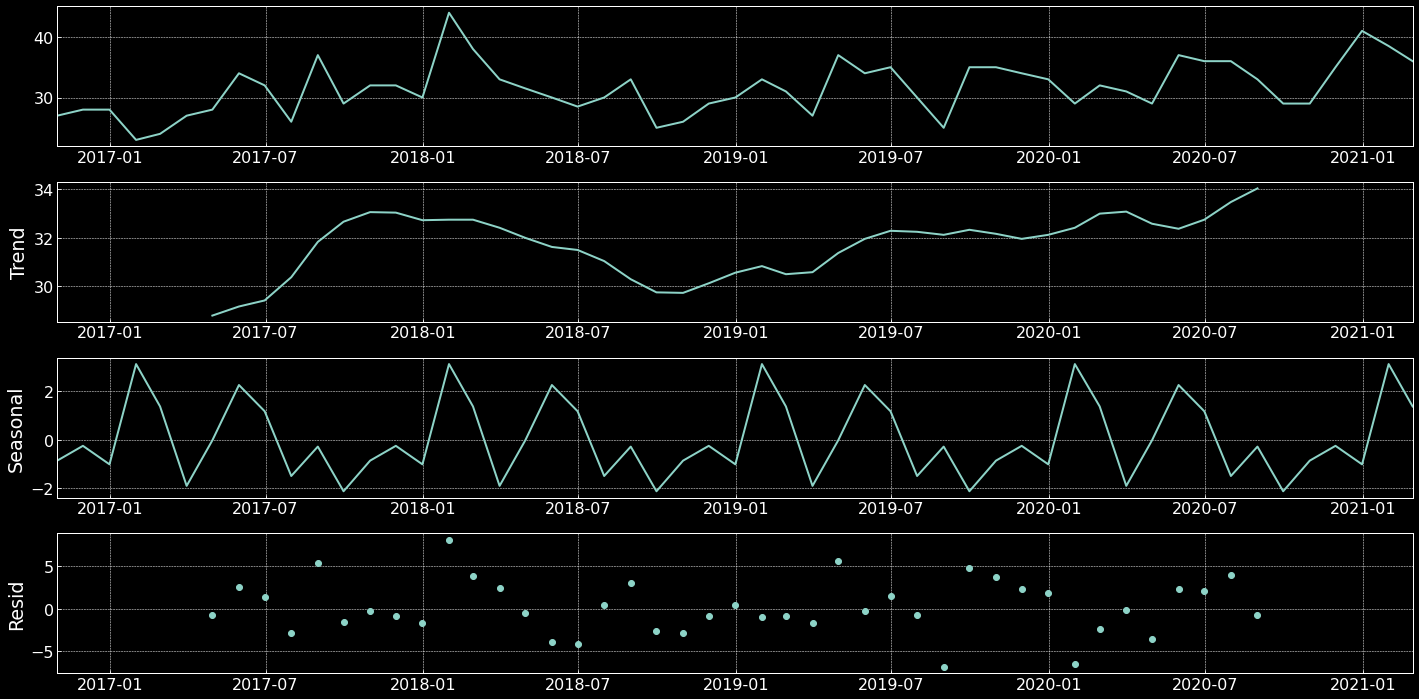

In [78]:
model = seasonal_decompose(df1[["p_len"]], model="add", period=12)
with plt.rc_context():
    plt.rc("figure", figsize=(20, 10),)
    model.plot(); 
plt.tight_layout()

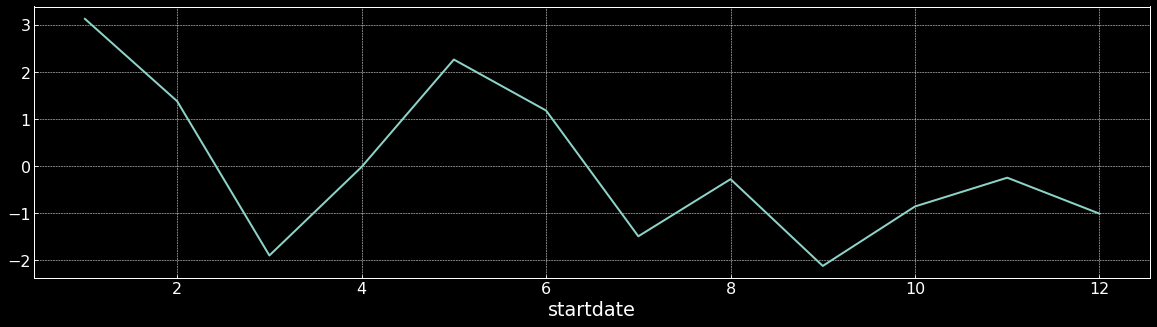

In [80]:
seasonal = model.seasonal.groupby(model.seasonal.index.month).mean()
seasonal.plot.line();

In [85]:
def create_forecast_index(start, horizon=30, freq="M"):
    return pd.date_range(start + pd.tseries.frequencies.to_offset(freq), periods=horizon, freq=freq, name="Time")
forecast_index=create_forecast_index(df1.index[-1])

In [87]:
df1.tail()

,length,p_len
startdate,,
2020-10-31,5.0,29.0
2020-11-30,4.0,35.0
2020-12-31,5.0,41.0
2021-01-31,5.0,38.5
2021-02-28,5.0,36.0


In [92]:
df.tail()

,length,p_len
startdate,,
2020-09-22,5,29
2020-10-21,5,29
2020-11-19,4,35
2020-12-24,5,41
2021-02-03,5,36


C:\Users\dengj\Miniconda3\envs\mds574\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\dengj\Miniconda3\envs\mds574\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


<AxesSubplot:xlabel='startdate'>

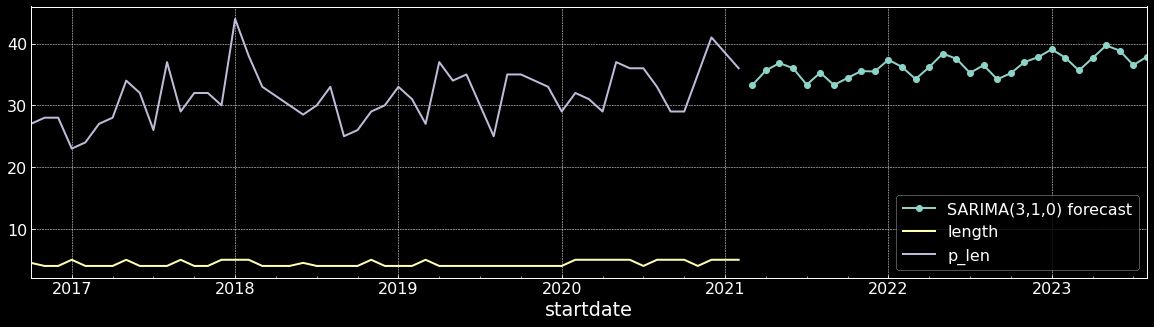

In [96]:
model_arima = ARIMA(df1["p_len"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
arima = pd.DataFrame({"SARIMA(3,1,0) forecast": model_arima.forecast(len(forecast_index)),},
                     index=forecast_index)
ax1 = arima.plot.line(marker='o')
df1.plot.line(ax=ax1)

In [97]:
arima

,"SARIMA(3,1,0) forecast"
Time,
2021-03-31,33.255345
2021-04-30,35.655351
2021-05-31,36.834149
2021-06-30,36.007223
2021-07-31,33.341269
2021-08-31,35.290227
2021-09-30,33.278999
2021-10-31,34.435965
2021-11-30,35.544110


<AxesSubplot:xlabel='startdate'>

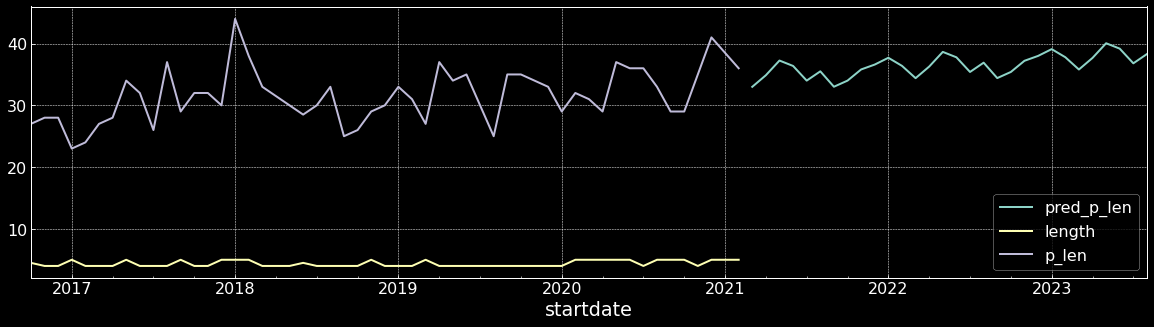

In [93]:

# ETS
model = ETSModel(df1["p_len"], error="add", trend="add", seasonal="add",
                ).fit()
ets = pd.DataFrame({"pred_p_len": model.forecast(len(forecast_index)),
                    "Label": "ETS"},
                   index=forecast_index)
ax1 = ets.plot.line()
df1.plot.line(ax=ax1)

In [91]:
ets

,p_len,Label
Time,,
2021-03-31,32.998345,ETS
2021-04-30,34.874479,ETS
2021-05-31,37.250750,ETS
2021-06-30,36.375684,ETS
2021-07-31,34.001853,ETS
2021-08-31,35.505119,ETS
2021-09-30,33.010505,ETS
2021-10-31,34.001509,ETS
2021-11-30,35.809876,ETS
